In [74]:
import collections
import glob
import itertools
import json
import matplotlib
rc_fonts = {
    "font.size": 14,
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

import s3dexp.db
import s3dexp.db.utils as dbutils
import s3dexp.db.models as models

from utils import get_by_expnames, pretty

## App Throughput vs CPU cores
Trying to find the "kink" in the curves.

In [80]:
dataset = 'jpeg/flickr50k'
ext = 'jpg'
hostname='cloudlet029'
cpu_exp = '-cores'
bw_exp = 'mbps'

df_all = pd.read_sql(
    'SELECT expname, avg_wall_ms, avg_cpu_ms, (1 / avg_wall_ms * 1000) as throughput, avg_mbyteps as bandwidth, num_workers FROM EurekaExp \
        WHERE basedir LIKE %s AND hostname=%s AND (expname LIKE %s OR expname LIKE %s)',
    s3dexp.db.engine,
    params=["%{}%".format(dataset), hostname, "%{}".format(cpu_exp), "%{}".format(bw_exp)])

df_all

,expname,avg_wall_ms,avg_cpu_ms,throughput,bandwidth,num_workers
0,smart_redness-sorted-2-cores,2.820590,4.326214,354.535718,371.448436,2
1,smart_redness-sorted-4-cores,1.450360,4.421666,689.484172,722.375219,4
2,smart_redness-sorted-8-cores,0.788677,4.539273,1267.946474,1328.432397,8
3,smart_redness-sorted-16-cores,0.725071,5.165821,1379.175268,1444.967233,16
4,smart_hash-sorted-2-cores,2.494959,3.787290,400.808177,419.928269,2
5,smart_hash-sorted-4-cores,1.299520,3.881319,769.515087,806.223916,4
6,smart_hash-sorted-8-cores,0.743786,4.037838,1344.472353,1408.608855,8
7,smart_hash-sorted-16-cores,0.725539,4.757552,1378.285777,1444.035309,16
8,smart_face-sorted-2-cores,33.335862,3.416143,29.997724,0.632338,2
9,smart_face-sorted-4-cores,33.334290,3.394012,29.999139,0.632368,4


In [81]:
workloads = ['redness', 'hash', 'resnet10', 'face']
markers = ['o', '^', 's', 'x']

### Actvie Disk

<IPython.core.display.Javascript object>


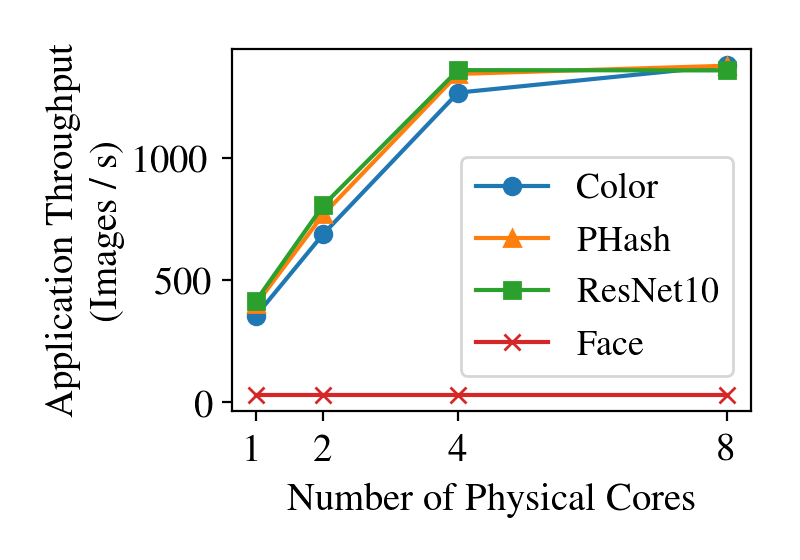

                         expname  avg_wall_ms  avg_cpu_ms   throughput  \
0   smart_redness-sorted-2-cores     2.820590    4.326214   354.535718   
1   smart_redness-sorted-4-cores     1.450360    4.421666   689.484172   
2   smart_redness-sorted-8-cores     0.788677    4.539273  1267.946474   
3  smart_redness-sorted-16-cores     0.725071    5.165821  1379.175268   

     bandwidth  num_workers  
0   371.448436            2  
1   722.375219            4  
2  1328.432397            8  
3  1444.967233           16  
                      expname  avg_wall_ms  avg_cpu_ms   throughput  \
0   smart_hash-sorted-2-cores     2.494959    3.787290   400.808177   
1   smart_hash-sorted-4-cores     1.299520    3.881319   769.515087   
2   smart_hash-sorted-8-cores     0.743786    4.037838  1344.472353   
3  smart_hash-sorted-16-cores     0.725539    4.757552  1378.285777   

     bandwidth  num_workers  
0   419.928269            2  
1   806.223916            4  
2  1408.608855            8  
3  

In [82]:
%matplotlib notebook

# (logical) cpu cores
cores = np.array([2, 4, 8, 16])

plt.figure(figsize=(4,2.8))

for workload, m in zip(workloads, markers):
    expnames = map(lambda c: 'smart_{}-sorted-{}-cores'.format(workload, c), cores)
    df = get_by_expnames(df_all, expnames)
    print df
    plt.plot(cores/2, df['throughput'], '-'+m, label=pretty(workload))   # workers = 2 * physical cores
    
plt.xticks(cores/2)
plt.xlabel('Number of Physical Cores')
plt.ylabel('Application Throughput\n(Images / s)')
plt.legend(bbox_to_anchor=(1., .4), fontsize=13, loc='center right')
plt.tight_layout()

plt.savefig('tput-vs-core.pdf', bbox_inches='tight')

### Baseline (only for internal)

<IPython.core.display.Javascript object>


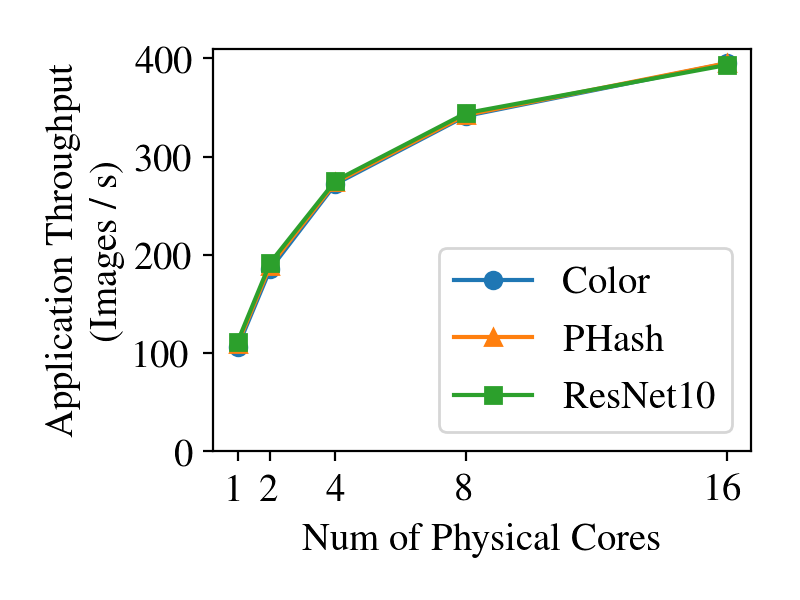

                    expname  avg_wall_ms  avg_cpu_ms  throughput  bandwidth  \
0   baseline_redness2-cores     9.437481   10.950314  105.960474   7.981273   
1   baseline_redness4-cores     5.391635   10.665969  185.472499  13.970366   
2   baseline_redness8-cores     3.674602   10.552949  272.138313  20.498305   
3  baseline_redness16-cores     2.928818   10.750078  341.434719  25.717926   
4  baseline_redness32-cores     2.532425    9.363218  394.878480  29.743477   

   num_workers  
0            2  
1            4  
2            8  
3           16  
4           32  
                 expname  avg_wall_ms  avg_cpu_ms  throughput  bandwidth  \
0   baseline_hash2-cores     9.165818   10.400901  109.101015   8.217828   
1   baseline_hash4-cores     5.293564   10.122427  188.908656  14.229188   
2   baseline_hash8-cores     3.652511   10.066371  273.784281  20.622285   
3  baseline_hash16-cores     2.919882   10.359692  342.479570  25.796628   
4  baseline_hash32-cores     2.530647    8.

In [83]:
%matplotlib notebook

# (logical) cpu cores
cores = np.array([2, 4, 8, 16, 32])

plt.figure(figsize=(4,3))

for workload, m in zip(['redness', 'hash', 'resnet10'], markers):
    expnames = map(lambda c: 'baseline_{}{}-cores'.format(workload, c), cores)
    df = get_by_expnames(df_all, expnames)
    print df
    plt.plot(cores/2, df['throughput'], '-'+m, label=pretty(workload))   # workers = 2 * physical cores
    
plt.xticks(cores/2)
plt.xlabel('Num of Physical Cores')
plt.ylabel('Application Throughput\n(Images / s)')
plt.ylim(0, None)
plt.legend(loc='best')
plt.tight_layout()


## App Throughput vs. (Emulated) Bus Bandwidth 

In [77]:
num_workers = 8  # TODO: use 8 cores
df_all = pd.read_sql(
    'SELECT expname, avg_wall_ms, (1 / avg_wall_ms * 1000) as throughput, num_workers FROM EurekaExp \
        WHERE basedir LIKE %s AND hostname=%s AND (expname LIKE %s OR expname LIKE %s) AND num_workers=%s',
    s3dexp.db.engine,
    params=["%{}%".format(dataset), hostname, "%{}".format(cpu_exp), "%{}".format(bw_exp), num_workers])

print(df_all)

                           expname  avg_wall_ms   throughput  num_workers
0     smart_redness-sorted-8-cores     0.788677  1267.946474            8
1        smart_hash-sorted-8-cores     0.743786  1344.472353            8
2        smart_face-sorted-8-cores    33.334267    29.999160            8
3    smart_resnet10-sorted-8-cores     0.735205  1360.164597            8
4          baseline_redness8-cores     3.674602   272.138313            8
5             baseline_hash8-cores     3.652511   273.784281            8
6         baseline_resnet108-cores     5.456883   183.254794            8
7     smart_redness-sorted-500mbps     2.100997   475.964605            8
8        smart_hash-sorted-500mbps     2.101255   475.905978            8
9        smart_face-sorted-500mbps    33.334412    29.999029            8
10   smart_resnet10-sorted-500mbps     2.106508   474.719284            8
11   smart_resnet10-sorted-250mbps     4.198382   238.187002            8
12    smart_redness-sorted-250mbps    

<IPython.core.display.Javascript object>


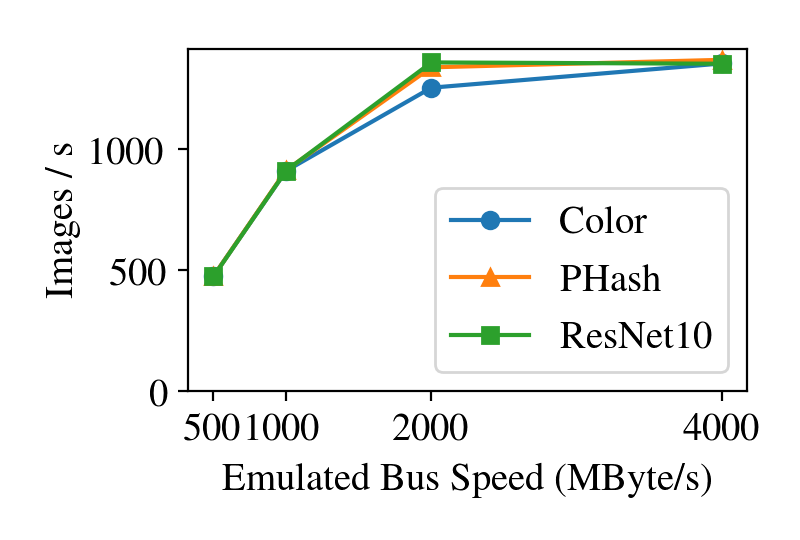

                         expname  avg_wall_ms   throughput  num_workers
0   smart_redness-sorted-500mbps     2.100997   475.964605            8
1  smart_redness-sorted-1000mbps     1.097968   910.773730            8
2  smart_redness-sorted-2000mbps     0.797383  1254.101889            8
3  smart_redness-sorted-4000mbps     0.738447  1354.193041            8
                      expname  avg_wall_ms   throughput  num_workers
0   smart_hash-sorted-500mbps     2.101255   475.905978            8
1  smart_hash-sorted-1000mbps     1.094303   913.824041            8
2  smart_hash-sorted-2000mbps     0.747282  1338.182211            8
3  smart_hash-sorted-4000mbps     0.730386  1369.138308            8
                          expname  avg_wall_ms   throughput  num_workers
0   smart_resnet10-sorted-500mbps     2.106508   474.719284            8
1  smart_resnet10-sorted-1000mbps     1.096662   911.858186            8
2  smart_resnet10-sorted-2000mbps     0.736136  1358.444629            8
3  

In [79]:
# Bus Bandwidth
bws = np.array([500, 1000, 2000, 4000])

# throughputs = []
# for workload in workloads:             
             
#     df = throughput_bws(workload, bws)

#     throughputs.append(df)
#     width = .35
#     print(df)

# fig, axes = plt.subplots(4, figsize=(5,6), sharex=True)

# for i, w in enumerate(['Color', 'PHash', 'Resnet10', 'Face']):
#     axes[i].plot(bws, throughputs[i], 'o-', color='orange')
#     axes[i].set_xticks(bws, minor=True)
#     axes[i].title.set_text(w)
#     axes[i].set_ylabel('Throughput', fontsize=10)

# plt.tight_layout()
# plt.xlabel("Bus Bandwidth")
# plt.show()


plt.figure(figsize=(4,2.7))

for workload, m in zip(workloads[:-1], markers):
    expnames = map(lambda bw: 'smart_{}-sorted-{}mbps'.format(workload, bw), bws)
    df = get_by_expnames(df_all, expnames)
    print(df)
    plt.plot(bws, df['throughput'], '-'+m, label=pretty(workload))
    
plt.xticks(bws)
plt.ylim(0, None)
# plt.xlim(0, None)
plt.xlabel('Emulated Bus Speed (MByte/s)')
plt.ylabel('Images / s')
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('tput-vs-bw.pdf', bbox_inches='tight')